<a href="https://colab.research.google.com/github/colaprograms/2019-hackathon-ocr-wymbah/blob/master/notebooks/ctc_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, torch, re, sys
import numpy as np
import matplotlib.pyplot as p
import random, PIL

In [59]:
os.chdir("/content")
if not os.path.exists("/content/AI4Good---Meza-OCR-Challenge"):
  !git clone https://github.com/Charitable-Analytics-International/AI4Good---Meza-OCR-Challenge
if not os.path.exists("/content/2019-hackathon-ocr-wymbah"):
  !git clone https://github.com/colaprograms/2019-hackathon-ocr-wymbah
os.chdir("/content/2019-hackathon-ocr-wymbah")
!git pull

from importlib import reload
import util.file
reload(util.file)

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/colaprograms/2019-hackathon-ocr-wymbah
   2b62f46..45b46d3  master     -> origin/master
Updating 2b62f46..45b46d3
Fast-forward
 util/.file.py.swp | Bin 16384 -> 0 bytes
 util/file.py      |  12 ++++++------
 2 files changed, 6 insertions(+), 6 deletions(-)
 delete mode 100644 util/.file.py.swp
Using path /content/AI4Good---Meza-OCR-Challenge


<module 'util.file' from '/content/2019-hackathon-ocr-wymbah/util/file.py'>

47


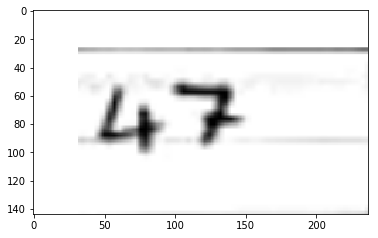

In [66]:
from util.file import FileHolder
fh = FileHolder()
inp, outp = fh.get_batch(1)

for file, val in zip(inp, outp):
  print(val)
  p.imshow(file)
  p.show()

def to_tensor(buf):
  return torch.Tensor(buf - 0.5).unsqueeze(0).permute(0, 3, 1, 2)

def get_batch(batchsize, validation=False):
  inp, outp = fh.get_batch(batchsize, validation)
  inp = list(map(to_tensor, inp))
  return inp, outp

In [0]:
import torch.nn as nn
import torch.optim as optim
import torchvision

resnet = torchvision.models.resnet.resnet34(True)

"Cut off the last two layers"
def forward(self, x):
  x = self.conv1(x)
  x = self.bn1(x)
  x = self.relu(x)
  x = self.maxpool(x)

  x = self.layer1(x)
  x = self.layer2(x)
  x = self.layer3(x)
  x = self.layer4(x)

  return x

import types
resnet.forward = types.MethodType(forward, resnet)

In [226]:
image_tensor = torch.Tensor(image)
image_tensor = torch.unsqueeze(image_tensor, 0)
image_tensor = image_tensor.permute(0, 3, 1, 2)
out = resnet(image_tensor)
print(out)
print(out.shape)

tensor([[[[0.0000e+00, 8.4632e-03, 4.4118e-01,  ..., 3.5947e-01,
           0.0000e+00, 0.0000e+00],
          [1.5710e+00, 1.6492e+00, 4.3799e-01,  ..., 1.9591e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.5652e+00,
           1.0369e-01, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 2.7234e-01,  ..., 4.7540e+00,
           1.5719e+00, 0.0000e+00]],

         [[8.1148e-01, 6.8881e-01, 1.4770e+00,  ..., 2.5300e+00,
           2.8111e-01, 0.0000e+00],
          [0.0000e+00, 1.1480e-01, 1.6761e+00,  ..., 3.0082e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 3.6867e-01,  ..., 6.7188e-02,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 7.3576e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.6493e-01,
           6.6963e-01,